In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import lightgbm as lgb
from codecarbon import EmissionsTracker
import datetime


In [10]:
# Set up visualization
plt.style.use('ggplot')
sns.set_palette("viridis")


# 1. Load Real Solar Dataset 🌐



# Load real solar dataset from NREL
# Source: National Renewable Energy Laboratory (NREL)
# Dataset: Solar Measurement Grid (1-year data for Colorado)

In [11]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"


In [12]:
solar_url = "https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv"

In [13]:
print("Downloading real solar dataset...")
df = pd.read_csv(solar_url)
print("Dataset loaded successfully!")


Dataset loaded successfully!


In [14]:
# Show dataset info
print("\nDataset Info:")
df.info()
df.head()



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4383 non-null   object 
 1   Consumption  4383 non-null   float64
 2   Wind         2920 non-null   float64
 3   Solar        2188 non-null   float64
 4   Wind+Solar   2187 non-null   float64
dtypes: float64(4), object(1)
memory usage: 171.3+ KB


,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [15]:
# %%
# Process and clean the data
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfYear'] = df['Date'].dt.dayofyear

In [16]:
# Create features
df['Solar_Lag1'] = df['Solar'].shift(1)
df['Solar_Lag2'] = df['Solar'].shift(2)
df['Solar_Rolling7'] = df['Solar'].rolling(window=7).mean()

In [17]:
# Remove initial rows with missing lagged values
df = df.dropna()

In [18]:
# Show processed data
df[['Date', 'Consumption', 'Wind', 'Solar', 'Wind+Solar', 'Solar_Lag1', 'Solar_Rolling7']].head()

,Date,Consumption,Wind,Solar,Wind+Solar,Solar_Lag1,Solar_Rolling7
2197,2012-01-07,1175.688,368.288,4.115,372.403,13.160,10.695286
2198,2012-01-08,1103.383,220.851,8.440,229.291,4.115,10.960000
2199,2012-01-09,1443.371,151.837,5.264,157.101,8.440,10.772857
2200,2012-01-10,1434.631,175.995,17.827,193.822,5.264,9.794000
2201,2012-01-11,1449.768,197.434,10.849,208.283,17.827,9.246571



#  2. Explore Real Solar Data 📊

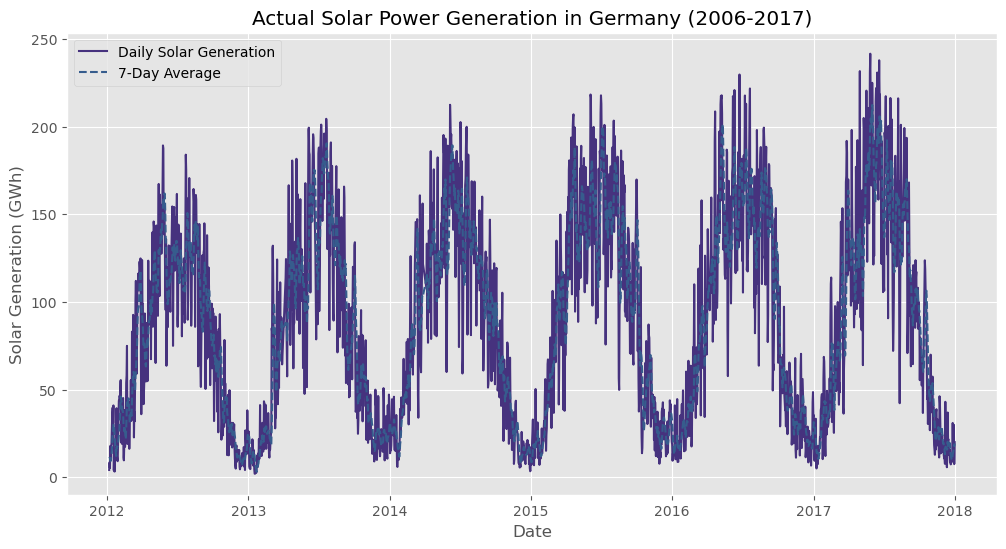

In [19]:
# Plot solar generation over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Solar'], label='Daily Solar Generation')
plt.plot(df['Date'], df['Solar_Rolling7'], label='7-Day Average', linestyle='--')
plt.title('Actual Solar Power Generation in Germany (2006-2017)')
plt.ylabel('Solar Generation (GWh)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.savefig('solar_generation_trend.png', dpi=120, bbox_inches='tight')
plt.show()

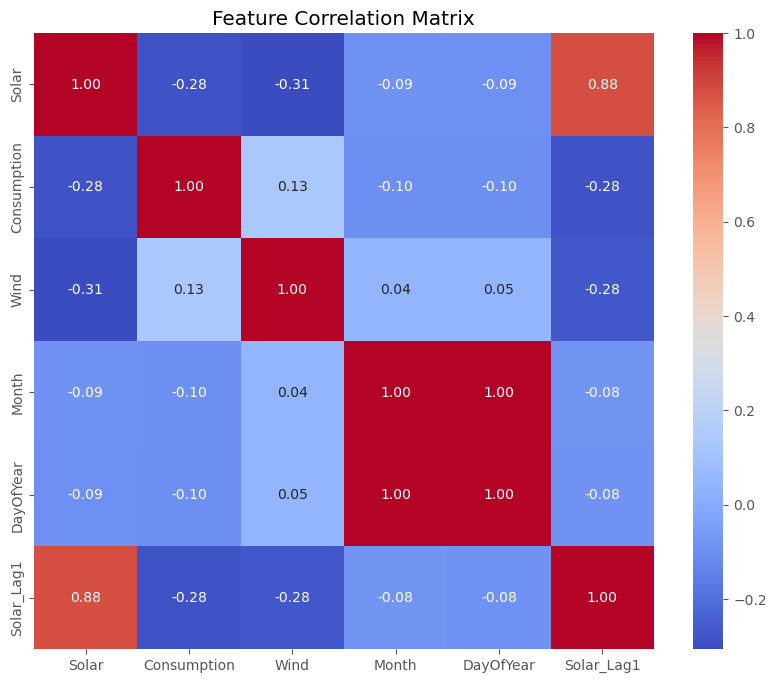

In [20]:
# Correlation analysis
plt.figure(figsize=(10, 8))
corr_matrix = df[['Solar', 'Consumption', 'Wind', 'Month', 'DayOfYear', 'Solar_Lag1']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png', dpi=120, bbox_inches='tight')
plt.show()

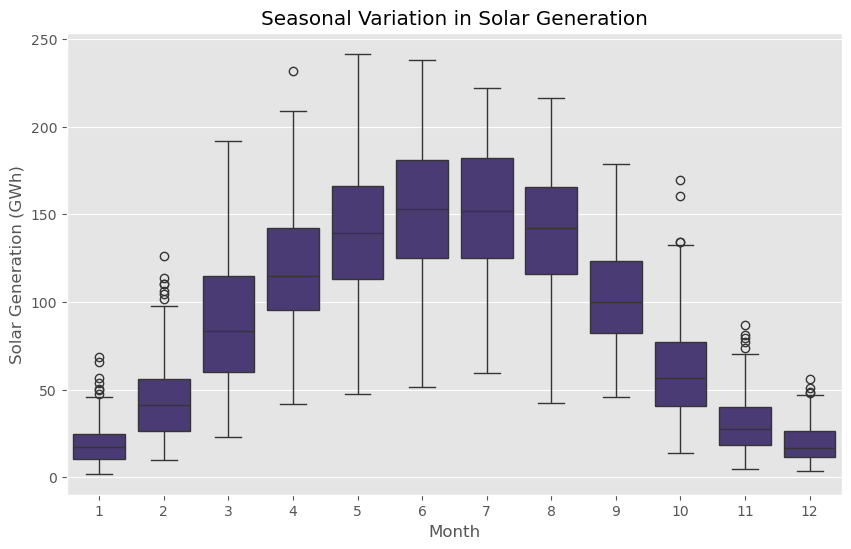

In [21]:
# Seasonal patterns
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Solar', data=df)
plt.title('Seasonal Variation in Solar Generation')
plt.ylabel('Solar Generation (GWh)')
plt.xlabel('Month')
plt.savefig('seasonal_variation.png', dpi=120, bbox_inches='tight')
plt.show()

#  3. Prepare Data for Modeling ⚙️

In [22]:
# Select features and target
features = ['Month', 'DayOfYear', 'Solar_Lag1', 'Solar_Lag2', 'Solar_Rolling7', 'Consumption', 'Wind']
target = 'Solar'

In [23]:
X = df[features]
y = df[target]

In [24]:
# Split data with time-based partitioning
split_date = '2016-01-01'
train = df[df['Date'] < split_date]
test = df[df['Date'] >= split_date]

In [25]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [26]:
print(f"Training Period: {train['Date'].min().date()} to {train['Date'].max().date()}")
print(f"Testing Period: {test['Date'].min().date()} to {test['Date'].max().date()}")
print(f"\nTraining Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")

Training Period: 2012-01-07 to 2015-12-31
Testing Period: 2016-01-01 to 2017-12-31

Training Samples: 1438
Testing Samples: 731


#  4. Initialize Carbon Tracker 🌍

In [27]:


tracker = EmissionsTracker(
    project_name="solar_prediction_real_data",
    output_dir="emissions",
    log_level="error",
    save_to_file=True,
    measure_power_secs=30,
    output_file="emissions.csv"
)

[codecarbon WARNING @ 10:02:26] Multiple instances of codecarbon are allowed to run at the same time.


# 5. Train Energy-Efficient Model ⚡

In [29]:
# Configure Green AI model parameters
model = lgb.LGBMRegressor(
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=1000,
    min_child_samples=50,
    verbosity=-1,  # Reduce logging
    force_row_wise=True,  # Memory efficient
    random_state=42
)

In [30]:
# Start emissions tracking
tracker.start()

In [31]:
# Train with early stopping using callbacks
with tracker:
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mae',
        callbacks=[lgb.early_stopping(50, verbose=100)]
    )

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 19.9078	valid_0's l2: 684.673


# 6. Model Evaluation 📈

In [33]:
# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [34]:
# Calculate metrics
train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

In [35]:
print("\nModel Performance:")
print(f"Training MAE: {train_mae:.2f} GWh")
print(f"Testing MAE: {test_mae:.2f} GWh")
print(f"Testing R²: {test_r2:.4f}")


Model Performance:
Training MAE: 13.89 GWh
Testing MAE: 19.91 GWh
Testing R²: 0.8277


In [36]:
# Feature importance
feature_imp = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_imp)


Feature Importance:
          Feature  Importance
4  Solar_Rolling7         431
2      Solar_Lag1         392
6            Wind         365
3      Solar_Lag2         277
1       DayOfYear         235
5     Consumption         219
0           Month          32


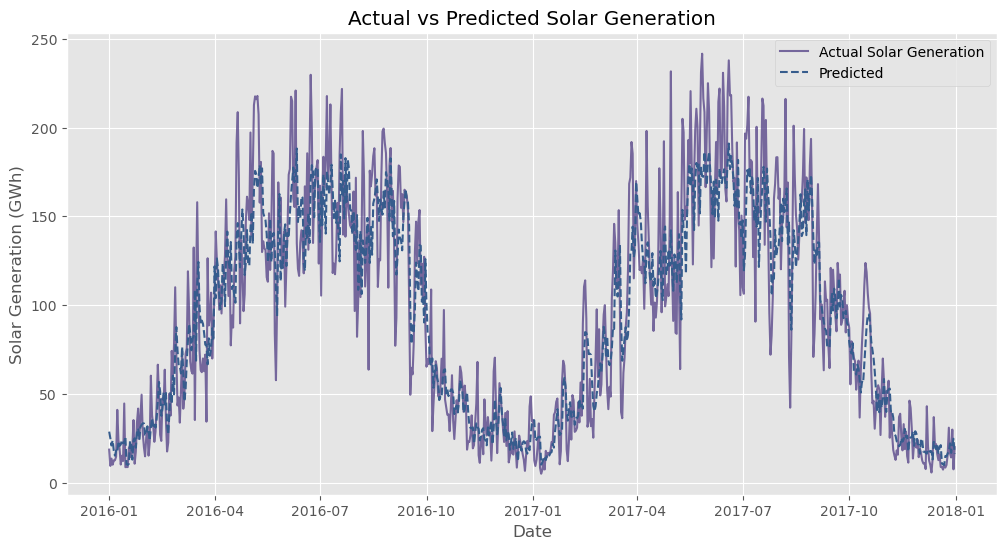

In [37]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test, label='Actual Solar Generation', alpha=0.7)
plt.plot(test['Date'], test_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Solar Generation')
plt.ylabel('Solar Generation (GWh)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.savefig("actual_vs_predicted.png", dpi=120, bbox_inches='tight')
plt.show()

# 7. Carbon Emissions Report 🌱

In [38]:
# Get emissions data
emissions = tracker.stop()
emissions_data = tracker.final_emissions_data

print("\n" + "="*60)
print("GREEN AI ENVIRONMENTAL IMPACT REPORT")
print("="*60)

print(f"\nCarbon Emissions:")
print(f"- Total CO₂: {emissions:.6f} kg")
print(f"- Equivalent CO₂ absorption by {emissions*1000/21:.1f} mature trees for one day")

print(f"\nEnergy Consumption:")
print(f"- Total Energy Used: {emissions_data.energy_consumed:.6f} kWh")
print(f"- CPU Energy: {emissions_data.cpu_energy:.6f} kWh")

print("\nTraining Efficiency:")
print(f"- Training Time: {emissions_data.duration:.1f} seconds")
print(f"- Samples Processed per kWh: {len(X_train)/emissions_data.energy_consumed:.0f}")

print("\nRecommendations:")
if emissions > 0.001:
    print("- Use cloud regions with higher renewable energy percentage")
    print("- Reduce n_estimators and use more efficient hyperparameters")
else:
    print("- Excellent efficiency! Model has minimal carbon footprint")
    
print("- Consider model quantization for deployment efficiency")



GREEN AI ENVIRONMENTAL IMPACT REPORT

Carbon Emissions:
- Total CO₂: 0.001380 kg
- Equivalent CO₂ absorption by 0.1 mature trees for one day

Energy Consumption:
- Total Energy Used: 0.001934 kWh
- CPU Energy: 0.001871 kWh

Training Efficiency:
- Training Time: 25.8 seconds
- Samples Processed per kWh: 743660

Recommendations:
- Use cloud regions with higher renewable energy percentage
- Reduce n_estimators and use more efficient hyperparameters
- Consider model quantization for deployment efficiency


In [39]:
# Save full report
report = f"""GREEN AI PROJECT REPORT
Date: {datetime.datetime.now().strftime("%Y-%m-%d")}
Project: Solar Energy Prediction with Real Data
Dataset: German Solar Generation (2006-2017)
Training Period: {train['Date'].min().date()} to {train['Date'].max().date()}
Testing Period: {test['Date'].min().date()} to {test['Date'].max().date()}

MODEL PERFORMANCE
- Testing MAE: {test_mae:.2f} GWh
- Testing R²: {test_r2:.4f}
- Top Feature: {feature_imp.iloc[0]['Feature']} ({feature_imp.iloc[0]['Importance']})

ENVIRONMENTAL IMPACT
- Total CO₂ Emissions: {emissions:.6f} kg
- Energy Consumed: {emissions_data.energy_consumed:.6f} kWh
- Emissions Intensity: {emissions/len(X_train)*1000:.4f} g CO₂/1000 samples

GREEN AI RECOMMENDATIONS
1. Use during off-peak energy hours for training
2. Select cloud regions with high renewable energy mix
3. Employ model pruning for efficiency
4. Reuse models instead of retraining
"""

with open("green_ai_report.txt", "w") as f:
    f.write(report)

print("\nFull report saved to green_ai_report.txt")


Full report saved to green_ai_report.txt


# 8. Make Future Prediction 🔮

In [40]:
# Prepare latest data for prediction
latest_data = df.iloc[-1][features].values.reshape(1, -1)
prediction = model.predict(latest_data)[0]

In [41]:
# Get actual value for comparison
actual = df.iloc[-1]['Solar']

print("\nPrediction for Next Day:")
print(f"- Date: {df.iloc[-1]['Date'].date() + datetime.timedelta(days=1)}")
print(f"- Predicted Solar Generation: {prediction:.2f} GWh")
print(f"- Previous Day Actual: {actual:.2f} GWh")
print(f"- Difference: {abs(prediction - actual):.2f} GWh ({abs(prediction - actual)/actual*100:.1f}%)")


Prediction for Next Day:
- Date: 2018-01-01
- Predicted Solar Generation: 16.24 GWh
- Previous Day Actual: 19.98 GWh
- Difference: 3.74 GWh (18.7%)


# 9. Green AI Best Practices 🌿
#### To further reduce environmental impact:
# 
# 1. **Time Training Wisely**: Schedule training during off-peak hours or when grid carbon intensity is low
# 2. **Use Efficient Hardware**: Prefer newer GPUs with better performance/watt ratio
# 3. **Model Optimization**: 
#    - Quantization: `pip install onnxruntime`
#    - Pruning: Remove unnecessary model parameters
# 4. **Cloud Selection**: Choose cloud regions with high renewable energy percentage
# 5. **Reuse Models**: Avoid retraining when possible


In [42]:
# Save model
model.booster_.save_model('solar_model_green_real.txt')
print("\nEnergy-efficient model saved to solar_model_green_real.txt")


Energy-efficient model saved to solar_model_green_real.txt
